In [3]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import seaborn as sns

In [4]:
base_dir = '../final_dataset3'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [6]:
#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Train,Val and Test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
)

Found 1606 images belonging to 2 classes.
Found 343 images belonging to 2 classes.
Found 345 images belonging to 2 classes.


In [7]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(229, 229, 3))

2025-01-09 12:39:58.862491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31124 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0


In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

In [9]:
model = Model(inputs=base_model.input, outputs=output_layer)

In [10]:
#Freeze early layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10


2025-01-09 12:40:31.205471: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
2025-01-09 12:40:33.170500: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6414e1e930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-09 12:40:33.170536: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-DGXS-32GB, Compute Capability 7.0
2025-01-09 12:40:33.180544: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736426433.292164   11372 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 [==============================] - 34s 440ms/step - loss: 0.8243 - accuracy: 0.7167 - val_loss: 0.3419 - val_accuracy: 0.8571
Epoch 2/10
51/51 [==============================] - 20s 390ms/step - loss: 0.3051 - accuracy: 0.8730 - val_loss: 0.4176 - val_accuracy: 0.8309
Epoch 3/10
51/51 [==============================] - 20s 384ms/step - loss: 0.2351 - accuracy: 0.8991 - val_loss: 0.3369 - val_accuracy: 0.8601
Epoch 4/10
51/51 [==============================] - 19s 382ms/step - loss: 0.2014 - accuracy: 0.9222 - val_loss: 0.2954 - val_accuracy: 0.8921
Epoch 5/10
51/51 [==============================] - 19s 376ms/step - loss: 0.1785 - accuracy: 0.9278 - val_loss: 0.2392 - val_accuracy: 0.9067
Epoch 6/10
51/51 [==============================] - 19s 378ms/step - loss: 0.1387 - accuracy: 0.9539 - val_loss: 0.2167 - val_accuracy: 0.9096
Epoch 7/10
51/51 [==============================] - 19s 383ms/step - loss: 0.1035 - accuracy: 0.9682 - val_loss: 0.2242 - val_accuracy: 0.9067
Epoch 8/10

In [12]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

11/11 [==============================] - 5s 417ms/step - loss: 0.2196 - accuracy: 0.9101
Test accuracy: 0.9101449251174927


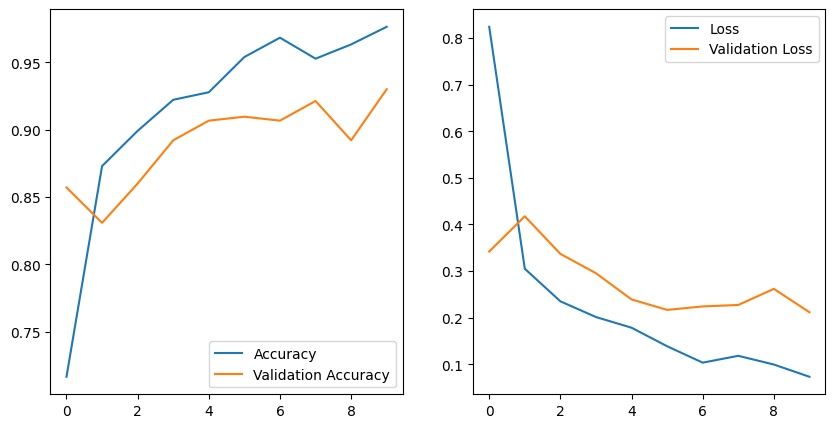

In [13]:
#Accuracy,Val accuracy, loss and val loss graphs
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [14]:
predictions = model.predict(test_generator)
binary_predictions = (predictions > 0.5).astype(int).flatten()

true_labels = test_generator.classes

11/11 [==============================] - 6s 337ms/step


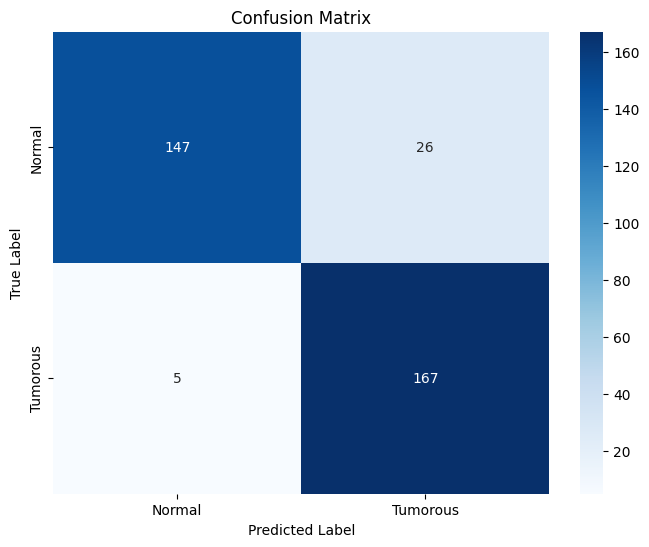

In [15]:
#Confussion matrix
cm = confusion_matrix(true_labels, binary_predictions)
classes = ['Normal','Tumorous']
#Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()